In [1]:
from excel_reader import ExcelReader

In [2]:
from iv_calculator import calculate_iv_for_chain

In [3]:
import pandas as pd

In [4]:
import numpy as np

In [5]:
excel_reader = ExcelReader(
    excel_file="petr_options_chain_3.xlsx",
    sheet_name="Sheet1",
    iv_col="I",
    start_row=2,
    end_row=1925,
    bid_col="E",
    ask_col="F",
    last_price_col="B",
    strike_col="C",
    open_interest_col="H",
    volume_col="D",
    ticker_col="A",
    maturity_col="G",
    spot_price_col="J"
)

In [6]:
with_forward = excel_reader.add_forward_price()

In [7]:
with_forward

,bid,ask,lastPrice,Strike,openInterest,volume,ticker,Expiry,IV,SpotPrice,Type,DaysToExpiry,TimeToExpiry,Forward
0,0.0,0.0,0.00,22.40,0.0,0.0,PETRJ224W4,24/10/2025,0.0,29.73,call,5,0.019841,29.812557
1,0.0,0.0,6.68,22.90,100.0,100.0,PETRJ229W4,24/10/2025,0.0,29.73,call,5,0.019841,29.812557
2,0.0,0.0,0.00,23.40,0.0,0.0,PETRJ234W4,24/10/2025,0.0,29.73,call,5,0.019841,29.812557
3,0.0,0.0,0.00,23.90,0.0,0.0,PETRJ239W4,24/10/2025,0.0,29.73,call,5,0.019841,29.812557
4,0.0,0.0,5.30,24.40,2300.0,300.0,PETRJ244W4,24/10/2025,0.0,29.73,call,5,0.019841,29.812557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1919,0.0,0.0,2.73,37.50,1314400.0,166500.0,PETRP381,17/04/2026,0.0,29.73,put,124,0.492063,31.846529
1920,0.0,0.0,4.87,37.75,26000.0,7000.0,PETRP383,17/04/2026,0.0,29.73,put,124,0.492063,31.846529
1921,0.0,0.0,4.81,38.00,1000.0,10000.0,PETRP394,17/04/2026,0.0,29.73,put,124,0.492063,31.846529
1922,0.0,0.0,6.00,38.25,86300.0,300.0,PETRP48,17/04/2026,0.0,29.73,put,124,0.492063,31.846529


In [8]:
result = calculate_iv_for_chain(with_forward, 0.15, min_volume=100, max_rel_spread=0.5, min_days_expiry=2)

In [9]:
result

,TimeToExpiry,Strike,ImpliedVolatility,Type,Forward
14,0.019841,29.40,0.184659,call,29.812557
15,0.019841,29.65,0.202744,call,29.812557
16,0.019841,29.90,0.189294,call,29.812557
18,0.019841,30.40,0.198232,call,29.812557
54,0.019841,28.90,0.239210,put,29.812557
...,...,...,...,...,...
1653,0.337302,32.25,0.219616,call,31.165090
1655,0.337302,32.75,0.241760,call,31.165090
1693,0.337302,27.00,0.282151,put,31.165090
1756,0.416667,31.25,0.244763,call,31.512704


In [10]:
from data_formatter import format_options_data_to_dict
formatted_data = format_options_data_to_dict(result, strike_col='Strike', iv_col='ImpliedVolatility', tte_col='TimeToExpiry', forward_col='Forward')

In [11]:
formatted_data

{'call': {0.01984126984126984:    Strike  ImpliedVolatility    Forward
  0   29.40           0.184659  29.812557
  1   29.65           0.202744  29.812557
  2   29.90           0.189294  29.812557
  3   30.40           0.198232  29.812557,
  0.03968253968253968:    Strike  ImpliedVolatility    Forward
  0    30.5           0.199696  29.895344
  1    31.0           0.197634  29.895344,
  0.07936507936507936:    Strike  ImpliedVolatility    Forward
  0    30.9           0.219094  30.061607,
  0.09523809523809523:     Strike  ImpliedVolatility    Forward
  0    28.72           0.256810  30.128371
  1    28.97           0.226839  30.128371
  2    29.22           0.245749  30.128371
  3    29.47           0.258216  30.128371
  4    29.72           0.230622  30.128371
  5    29.97           0.236914  30.128371
  6    30.22           0.237255  30.128371
  7    30.47           0.223537  30.128371
  8    30.72           0.232908  30.128371
  9    30.97           0.232446  30.128371
  10   31.22

In [12]:
from svi import calibration_loop
svi_params_calibrated, optimization_results = calibration_loop(formatted_data['call'])


SVI calibration finished.
Starting SVI calibration for each expiration slice...
Skipping TTM=0.0198 due to insufficient data points (4).
Skipping TTM=0.0397 due to insufficient data points (2).
Skipping TTM=0.0794 due to insufficient data points (1).
Calibrating for TTM = 0.0952 years...
  Success: True, Params: [0.0045 0.0111 0.4997 0.0142 0.0569]
Calibrating for TTM = 0.1746 years...
  Success: True, Params: [ 0.0063  0.0467 -0.4973  0.0589  0.0566]
Calibrating for TTM = 0.2460 years...
  Success: True, Params: [ 0.0089  0.0642 -0.4961  0.0609  0.0649]
Skipping TTM=0.3373 due to insufficient data points (2).
Skipping TTM=0.4167 due to insufficient data points (2).



Generating comparison plot for TTM = 0.1746...


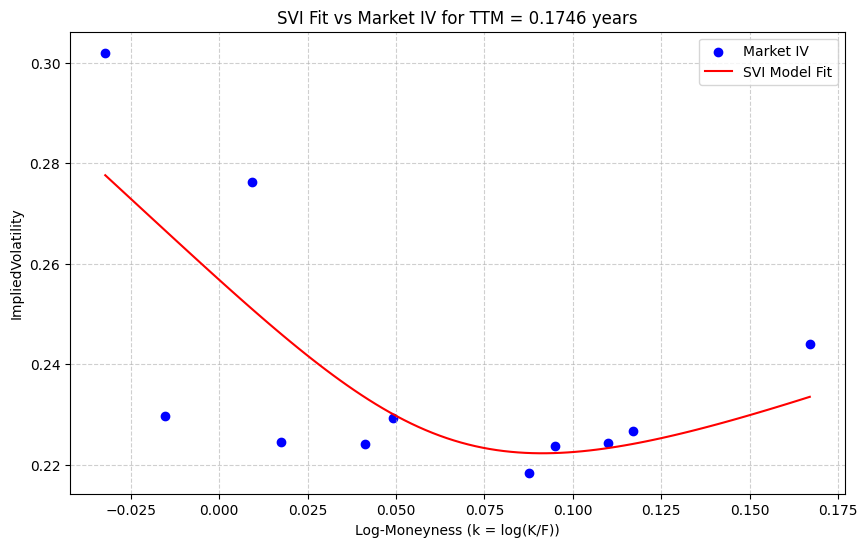


Generating 3D SVI volatility surface plot...


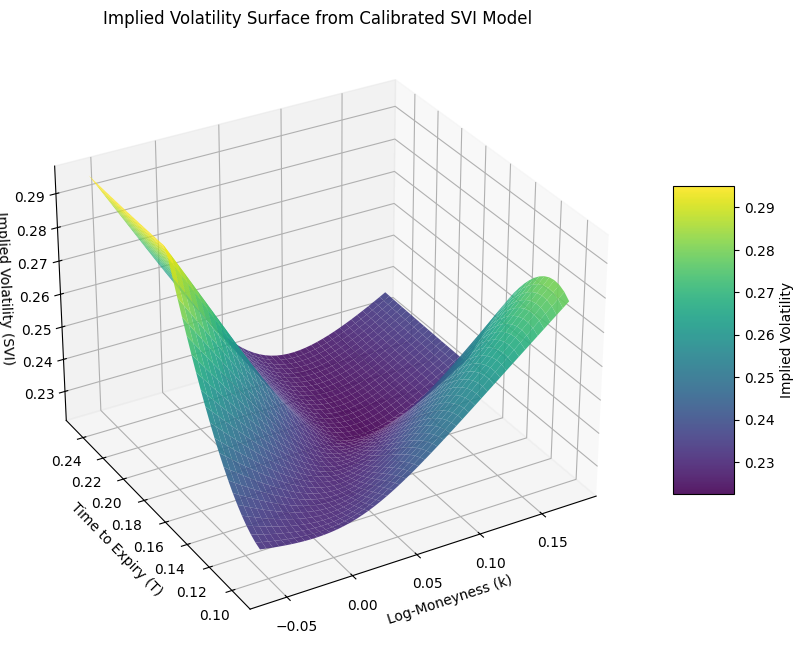


Section 4 finished.


In [13]:
from svi import single_expiry_comparison_plot
single_expiry_comparison_plot(formatted_data['call'], svi_params_calibrated)

In [14]:
# from cubic_interpolation import interpolate_volatility_surface, plot_interpolated_surface

In [15]:
# TICKER_SYMBOL: str = "AAPL" # Default ticker, can be overridden by environment variable
# RISK_FREE_RATE: float = 0.15 # Example risk-free rate (annualized)
# # Filter thresholds for option data cleaning
# MIN_VOLUME: int = 100
# MAX_REL_SPREAD: float = 0.50 # Maximum relative spread (Spread / MidPrice)
# MIN_DAYS_TO_EXPIRY: int = 1 # Minimum days to expiry to include
# MIN_IV: float = 0.01 # Minimum plausible IV
# MAX_IV: float = 4.00 # Maximum plausible IV
# # Interpolation Grid Resolution
# N_STRIKES_GRID: int = 100
# N_EXPIRIES_GRID: int = 100
# INTERPOLATION_METHOD: str = 'cubic' # 'linear' or 'cubic'

In [16]:
# print(f"\nInterpolating the volatility surface using '{INTERPOLATION_METHOD}' method...")
# T_grid, K_grid, iv_surface_interpolated = interpolate_volatility_surface(
#     iv_data=result,
#     method=INTERPOLATION_METHOD,
#     n_strikes=N_STRIKES_GRID,
#     n_expiries=N_EXPIRIES_GRID
# )

In [17]:
# if T_grid.size > 0: # Check if interpolation produced a grid
#     print("Plotting the interpolated surface...")
#     plot_title = (f"{TICKER_SYMBOL} Implied Volatility Surface\n"
#                     f"({INTERPOLATION_METHOD.capitalize()} Interpolation, "
#                     f"{N_EXPIRIES_GRID}x{N_STRIKES_GRID} Grid)")
#     plot_interpolated_surface(
#         T_grid,
#         K_grid,
#         iv_surface_interpolated,
#         filename="plot.png",
#         title=plot_title
#     )
# else:
#     print("Interpolation failed or yielded no usable grid. Cannot plot surface.")
#     # Ensure plot file is created even if interpolation failed
#     plot_interpolated_surface(np.array([]), np.array([]), np.array([]), filename='plot.png', title=f"{TICKER_SYMBOL} IV Surface (Interpolation Failed)")

# print("\n--- Script execution finished ---")